## Part A: Use convnet to classify whether images contain either a dog or a cat.

* Understanding convolutional neural networks (convnets)
* Using data augmentation to mitigate overfitting

Get the data from google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the train and test data (Source: https://www.kaggle.com/competitions/dogs-vs-cats/data)

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat)



In [3]:

#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset/cats-vs-dogs/train.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp/catdog') #Extracts the files into the /tmp folder
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset/cats-vs-dogs/test1.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp/catdog') #Extracts the files into the /tmp folder
zip_ref.close()


Re-organize the file so image_dataset_from_directory can do its job (https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [4]:
import shutil

srcpath = '/tmp/catdog/train'
destpath = '/tmp/catdog/train/'

# image names are in this format 'cat/dog.number' (ex. dog.124)
for root, subFolders, files in os.walk(srcpath):
    for file in files:
      # the first three letters are 'cat' or 'dog'. Use that as class name.
        classname = file[:3] + '/'
        subFolder = os.path.join(destpath, classname)
        # make the directory
        if not os.path.isdir(subFolder):
            os.makedirs(subFolder)
        # move the images to the right folder
        shutil.move(os.path.join(root, file), subFolder)

print('Moved train files.')


Moved train files.


Develop the model

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

25000 images and 2 classes (cat/dog) found as expected.

In [6]:
train_dir = '/tmp/catdog/train'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  color_mode="rgb",
  batch_size=32,
  validation_split=0.2,
  subset="both",
  image_size=(180, 180),
  seed=42
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


In [7]:
# the original dataset is too large so truncate it
# each batch has 20000/32 = 625 for train and 5000/32 = 156 for val

train_ds = train_ds.take(50)
val_ds = val_ds.take(20)

Visualize data

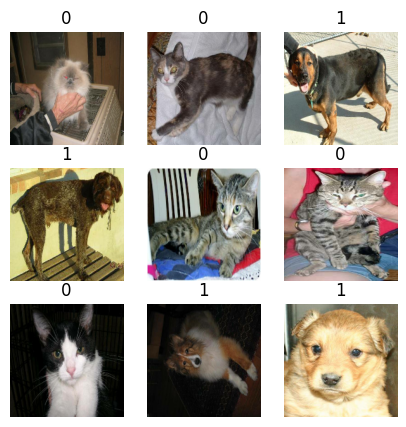

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        plt.title((labels[i]).numpy())
        plt.axis("off")

Build the model.

In [23]:
# 180 x 180 images with RGB channels
inputs = keras.Input(shape=(180, 180, 3))

# rescale to floats for easier calculation
x = layers.Rescaling(1./255)(inputs)

# series of convolution layers with increasing kernel size to capture more features
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)

# max pooling for feature capturing
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

# Convert the feature map that it received from the max-pooling layer
# into a format that the dense layers can understand.
x = layers.Flatten()(x)

# sigmoid for the binary ouput
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [24]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [33]:
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
)

Epoch 1/30
50/50 [==============================] - 160s 3s/step - loss: 0.2737 - accuracy: 0.8844 - val_loss: 0.5290 - val_accuracy: 0.7859
Epoch 2/30
50/50 [==============================] - 162s 3s/step - loss: 0.2215 - accuracy: 0.9106 - val_loss: 0.6013 - val_accuracy: 0.7563
Epoch 3/30
50/50 [==============================] - 151s 3s/step - loss: 0.1942 - accuracy: 0.9262 - val_loss: 0.6482 - val_accuracy: 0.7516
Epoch 4/30
50/50 [==============================] - 158s 3s/step - loss: 0.1729 - accuracy: 0.9306 - val_loss: 0.6773 - val_accuracy: 0.7734
Epoch 5/30
50/50 [==============================] - 150s 3s/step - loss: 0.1210 - accuracy: 0.9563 - val_loss: 0.8381 - val_accuracy: 0.7672
Epoch 6/30
50/50 [==============================] - 161s 3s/step - loss: 0.1138 - accuracy: 0.9525 - val_loss: 0.9141 - val_accuracy: 0.7719
Epoch 7/30
50/50 [==============================] - 180s 4s/step - loss: 0.0890 - accuracy: 0.9694 - val_loss: 0.8244 - val_accuracy: 0.7812
Epoch 8/30
50

Note: The train accuracy is increasing but validation accuracy stays at 0.77. This means the train is overfitting.

## Part 2: Make improvements by augmenting the data to increase the number of data.

In [8]:
# to add more variation in data
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

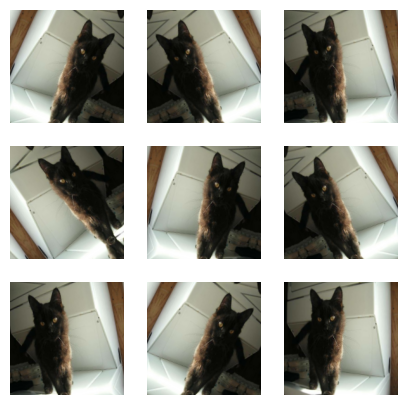

In [12]:
import matplotlib.pyplot as plt

# augmentation example
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
# Build a better model
# added augmentation
# added dropout to prevent overfitting

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [17]:
history = model.fit(
    train_ds,
    epochs=10,
    # callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
50/50 [==============================] - 219s 4s/step - loss: 0.7157 - accuracy: 0.5044 - val_loss: 0.6971 - val_accuracy: 0.4859
Epoch 2/10
50/50 [==============================] - 203s 4s/step - loss: 0.6956 - accuracy: 0.5144 - val_loss: 0.6938 - val_accuracy: 0.4859
Epoch 3/10
50/50 [==============================] - 209s 4s/step - loss: 0.6909 - accuracy: 0.5375 - val_loss: 0.6865 - val_accuracy: 0.5016
Epoch 4/10
50/50 [==============================] - 217s 4s/step - loss: 0.6815 - accuracy: 0.5525 - val_loss: 0.6691 - val_accuracy: 0.5703
Epoch 5/10
50/50 [==============================] - 224s 4s/step - loss: 0.6707 - accuracy: 0.6087 - val_loss: 0.7267 - val_accuracy: 0.5766
Epoch 6/10
50/50 [==============================] - 197s 4s/step - loss: 0.6533 - accuracy: 0.6263 - val_loss: 0.6159 - val_accuracy: 0.6391
Epoch 7/10
50/50 [==============================] - 198s 4s/step - loss: 0.6182 - accuracy: 0.6531 - val_loss: 0.7196 - val_accuracy: 0.5781
Epoch 8/10
50

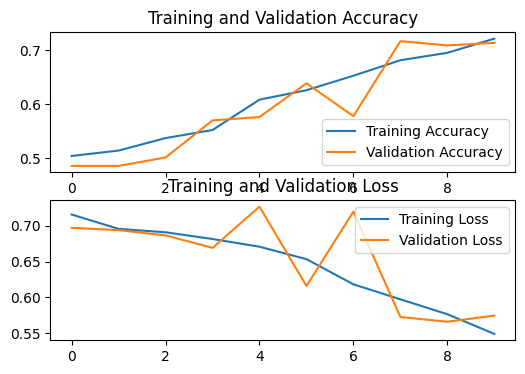

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(6, 4))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()